<a href="https://colab.research.google.com/github/omridrori/generative-models/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd

# Adding on from last lesson:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vgg16
from tqdm.notebook import tqdm


# Downloading the MNIST dataset we'll use in examples
import tarfile, requests, os

fname = 'MNIST.tar.gz'
name = 'mnist'
url = 'https://osf.io/y2fj6/download'

if not os.path.exists(name):
  print('\nDownloading MNIST dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print('\nDownloading MNIST completed..\n')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall(name)
    os.remove(fname)
else:
  print('MNIST dataset has been dowloaded.\n')

# Setting device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
vgg = vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [4]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [2]:
# credit: https://www.kaggle.com/danmoller/easy-style-transfer-with-pytorch
class VGGFeatureExtractor(nn.Module):
    def __init__(self, vggModel, layerIndices):
        super(VGGFeatureExtractor,self).__init__()
        self.features = vggModel.features
        
        #desired layers
        self.layerIndices = layerIndices
        self.outputCount = len(layerIndices)
        
        #making this model's parameters untrainble
        for p in self.parameters():
            p.requires_grad = False
        
    def forward(self,x):
        outputs = list()  #outputs from the selected layers
        
        #for each layer in the VGG
        for i, layer in enumerate(self.features.children()):
            x = layer(x) #apply the layer
            
            #if this layer is a desired layer, store its outputs
            if i in self.layerIndices:
                outputs.append(x)
                
                #check if we got all desired layers
                if i == self.layerIndices[-1]:
                    return outputs
                    
        return outputs


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58517  100 58517    0     0   589k      0 --:--:-- --:--:-- --:--:--  589k


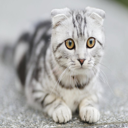

In [30]:
!curl --output cat.jpeg "https://images.pexels.com/photos/156934/pexels-photo-156934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
content_image = Image.open('cat.jpeg').resize((128, 128))
content_image

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  200k  100  200k    0     0  1911k      0 --:--:-- --:--:-- --:--:-- 1911k


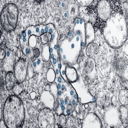

In [4]:

!curl --output style.jpeg "https://images.pexels.com/photos/3992944/pexels-photo-3992944.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
style_image = Image.open('style.jpeg').resize((128, 128))
style_image

In [5]:
def pil_to_torch(im):
  return torch.tensor(np.array(im)/255., dtype=torch.float).permute(2, 0, 1).unsqueeze(0)[:,:3,:,:]

In [10]:
content_im_tensor = pil_to_torch(content_image)
contentExtractor = VGGFeatureExtractor(vgg,  [14, 19])
target_content_features = contentExtractor(content_im_tensor)
[t.shape for t in target_content_features] 

[torch.Size([1, 256, 32, 32]), torch.Size([1, 512, 16, 16])]

In [11]:
styleExtractor = VGGFeatureExtractor(vgg,[5, 7, 10, 12, 17])
style_im_tensor = pil_to_torch(style_image)
target_style_features = styleExtractor(style_im_tensor)
[t.shape for t in target_style_features] 

[torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 512, 16, 16])]

[torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 512, 16, 16])]

In [13]:
def content_loss(im, target_content_features):
  im_content_features = contentExtractor(im)
  loss = 0
  for im_features, target_features in zip(im_content_features, target_content_features):
    loss += nn.L1Loss()(im_features, target_features)
  return loss/len(im_content_features)

im = torch.rand(1, 3, 128, 128)
content_loss(im, target_content_features)

tensor(2.7373)

In [14]:
# The gram matrix
def gram(x):
	b,c,h,w = x.size();
	x = x.view(b*c, -1);
	return torch.mm(x, x.t())/(h*w) # /(h*w) normalizes by size to avoid over-focusing on early layers
 
def style_loss(im, target_style_features):
  im_style_features = styleExtractor(im)
  loss = 0
  for im_features, target_features in zip(im_style_features, target_style_features):
    im_gram = gram(im_features)
    target_gram = gram(target_features)
    loss += F.mse_loss(im_gram, target_gram);
  return loss/len(im_style_features)

style_loss(im, target_style_features)

tensor(208.2309)

In [23]:
def training(content_image,style_image):


    content_im_tensor = pil_to_torch(content_image)
    contentExtractor = VGGFeatureExtractor(vgg,  [14, 19])
    target_content_features = contentExtractor(content_im_tensor)
    [t.shape for t in target_content_features] 

    styleExtractor = VGGFeatureExtractor(vgg,[5, 7, 10, 12, 17])
    style_im_tensor = pil_to_torch(style_image)
    target_style_features = styleExtractor(style_im_tensor)
    

    im = pil_to_torch(content_image)
    im.requires_grad = True

    # 
    optimizer = torch.optim.AdamW([im], lr=5e-3)

    # Weights we'll give to the different losses
    style_weight, content_weight = 0.5, 1

    losses = []  
    for i in range(75):
      optimizer.zero_grad()  
      loss = style_weight * style_loss(im.clip(0, 1), target_style_features)
      loss += content_weight * content_loss(im.clip(0, 1), target_content_features)
      loss.backward()  
      optimizer.step()  

      losses.append(loss.item())

      if i % 25 == 0:
        plt.imshow(im.clip(0, 1).detach().squeeze().permute(1, 2, 0))
        plt.show()
        print(loss.item())

    plt.plot(losses) 

In [29]:
content_image = Image.open('cat.jpeg').resize((128, 128))
content_image

UnidentifiedImageError: ignored

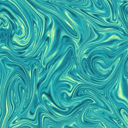

In [21]:
style_image = Image.open('style.jpg').resize((128, 128))
style_image

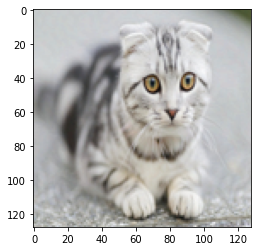

188.96392822265625


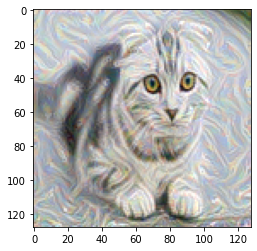

7.812997817993164


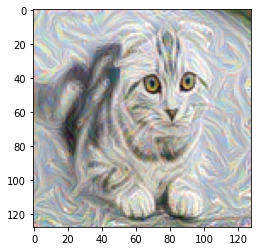

4.969642639160156


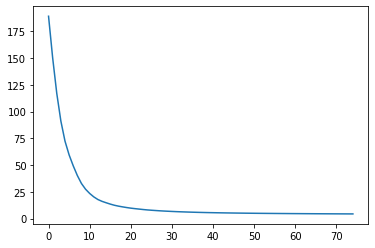

In [31]:
training(content_image,style_image)